In [20]:
import torch
from torch import nn
from d2l import torch as d2l

In [21]:
class Reshape(nn.Module):
    def forward(self, x):
        return x.reshape((-1, 1, 28, 28))

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), nn.AvgPool2d(kernel_size=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), nn.AvgPool2d(kernel_size=2),
    nn.Flatten(), 
    nn.Linear(16 * 5 * 5, 128), nn.Sigmoid(),
    nn.Linear(128, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [22]:
X = torch.rand(size=(10, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, '\t', X.shape)

Reshape 	 torch.Size([10, 1, 28, 28])
Conv2d 	 torch.Size([10, 6, 28, 28])
Sigmoid 	 torch.Size([10, 6, 28, 28])
AvgPool2d 	 torch.Size([10, 6, 14, 14])
Conv2d 	 torch.Size([10, 16, 10, 10])
Sigmoid 	 torch.Size([10, 16, 10, 10])
AvgPool2d 	 torch.Size([10, 16, 5, 5])
Flatten 	 torch.Size([10, 400])
Linear 	 torch.Size([10, 128])
Sigmoid 	 torch.Size([10, 128])
Linear 	 torch.Size([10, 84])
Sigmoid 	 torch.Size([10, 84])
Linear 	 torch.Size([10, 10])


In [23]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [24]:
next(iter(net.parameters())).size()
next(iter(net.parameters())).device

device(type='cpu')

In [25]:
def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [26]:
def train_ch6(net, train_iter, valid_iter, num_epochs, lr, device):
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights) 
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0]) 
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        valid_acc = evaluate_accuracy(net, valid_iter, device)
        animator.add(epoch + 1, (None, None, valid_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.428, train acc 0.839, test acc 0.803
18759.3 examples/sec on cuda:0


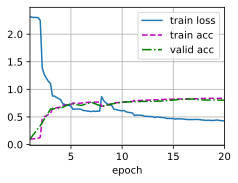

In [27]:
lr, num_epochs = 0.9, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())